In [61]:
#Імпорти
import pandas as pd
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [69]:
#Дані
base_path = '/content/drive/MyDrive/курс 4.1/NLP/Project/data'
main_df = pd.read_csv(os.path.join(base_path, 'general.csv'))

filtered_df = main_df.dropna(subset=['title', 'text', 'fake'])

start_dataset = main_df.head(5)
print(start_dataset)

# Вибір випадкових рядків з відфільтрованого датафрейму
mini_dataset_len=5000

if len(filtered_df) >= mini_dataset_len:
    mini_dataset = filtered_df.sample(n=mini_dataset_len, random_state=42)
else:
    raise ValueError("У датафреймі недостатньо рядків із заповненими обов'язковими полями для вибірки.")

#print(mini_dataset)

                                               title  \
0  Syria attack symptoms consistent with nerve ag...   
1  Homs governor says U.S. attack caused deaths b...   
2    Death toll from Aleppo bomb attack at least 112   
3        Aleppo bomb blast kills six Syrian state TV   
4  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                                text source  fake  
0  Wed 05 Apr 2017 Syria attack symptoms consiste...    nna     0  
1  Fri 07 Apr 2017 at 0914 Homs governor says U.S...    nna     0  
2  Sun 16 Apr 2017 Death toll from Aleppo bomb at...    nna     0  
3  Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...    nna     0  
4  Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...    nna     0  


In [64]:
#Надійність джерела
def calculate_source_reliability(df: pd.DataFrame) -> dict:
    """
    Розраховує відсоток правдивих новин для кожного джерела.
    Повертає словник {джерело: відсоток правдивих новин}.
    """
    if 'source' not in df.columns or 'fake' not in df.columns:
        raise ValueError("Датафрейм повинен мати колонки 'source' і 'fake'")
    reliability = df.groupby('source').apply(
        lambda group: (group['fake'].sum() / len(group)) * 100
    )
    # Повертаємо як словник
    return reliability.to_dict()

def evaluate_source(source: str, reliability_dict: dict) -> float:
    """
    Оцінює надійність конкретного джерела.
    Повертає відсоток правдивих новин для джерела або -1, якщо джерела немає у словнику.
    """
    return reliability_dict.get(source, -1)

In [65]:
#Довжина заголовку
def evaluate_title_length(title: str) -> int:
    """
    Оцінює довжину заголовку.
    Повертає кількість слів у заголовку.
    """
    if not title or not isinstance(title, str):
        return 0
    return len(word_tokenize(title))

In [66]:
#Наявність виразів впевненості
CONFIDENCE_PHRASES = [
    "definitely", "certainly", "without a doubt", "absolutely", "clearly",
    "surely", "undoubtedly", "no doubt", "evidently", "obviously", "sure",
    "positively", "unquestionably"
]
def detect_confidence_phrases(text: str) -> int:
    """
    Перевіряє наявність виразів впевненості у тексті.
    Повертає кількість знайдених виразів.
    """
    if not text or not isinstance(text, str):
        return 0
    tokens = word_tokenize(text.lower())
    confidence_count = sum(1 for token in tokens if token in CONFIDENCE_PHRASES)
    return confidence_count

In [53]:
#Середня довжина речення у тексті
def evaluate_avg_sentence_length(text: str) -> float:
    """
    Оцінює середню довжину речень у тексті.
    Повертає середню кількість слів у реченні.
    """
    if not text or not isinstance(text, str):
        return 0.0
    sentences = sent_tokenize(text)
    if not sentences:
        return 0.0
    word_counts = [len(word_tokenize(sentence)) for sentence in sentences]
    return sum(word_counts) / len(sentences)

In [70]:
#Перевірка працездатності

mini_dataset['title_length'] = mini_dataset['title'].apply(evaluate_title_length)
mini_dataset['avg_sentence_length'] = mini_dataset['text'].apply(evaluate_avg_sentence_length)
mini_dataset['confidence_presence'] = mini_dataset['text'].apply(detect_confidence_phrases)

print(mini_dataset[['title', 'title_length', 'avg_sentence_length', 'confidence_presence']])

KeyboardInterrupt: 

In [71]:
#Обчислення
#Для mini_dataset
mini_dataset['title_length'] = mini_dataset['title'].apply(evaluate_title_length)
mini_dataset['avg_sentence_length'] = mini_dataset['text'].apply(evaluate_avg_sentence_length)
mini_dataset['confidence_presence'] = mini_dataset['text'].apply(detect_confidence_phrases)

true_news = mini_dataset[mini_dataset['fake'] == 1]
fake_news = mini_dataset[mini_dataset['fake'] == 0]

reliability_dictionary = calculate_source_reliability(mini_dataset)

<ipython-input-64-695da1f0f87d>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reliability = df.groupby('source').apply(


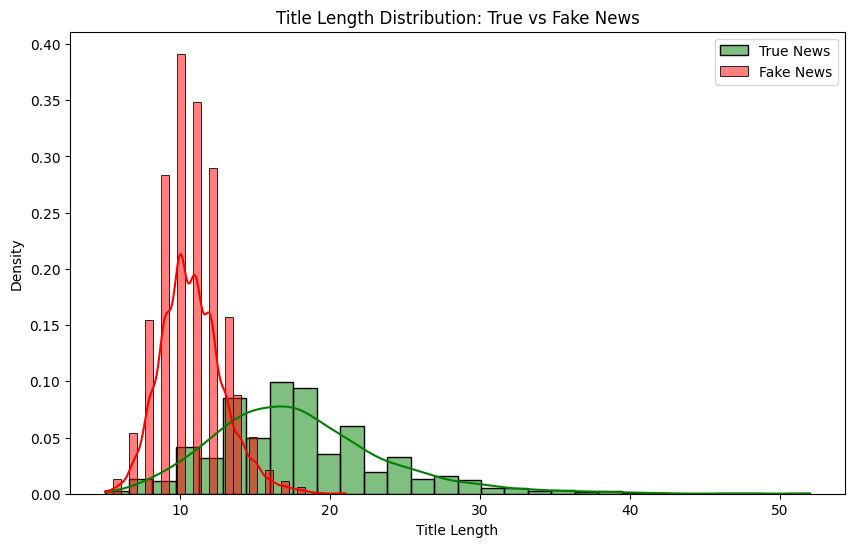

In [72]:
# 1. Графік для Довжина заголовку
plt.figure(figsize=(10, 6))
sns.histplot(true_news['title_length'], color='green', kde=True, label='True News', stat='density', bins=30)
sns.histplot(fake_news['title_length'], color='red', kde=True, label='Fake News', stat='density', bins=30)
plt.title('Title Length Distribution: True vs Fake News')
plt.xlabel('Title Length')
plt.ylabel('Density')
plt.legend()
plt.show()

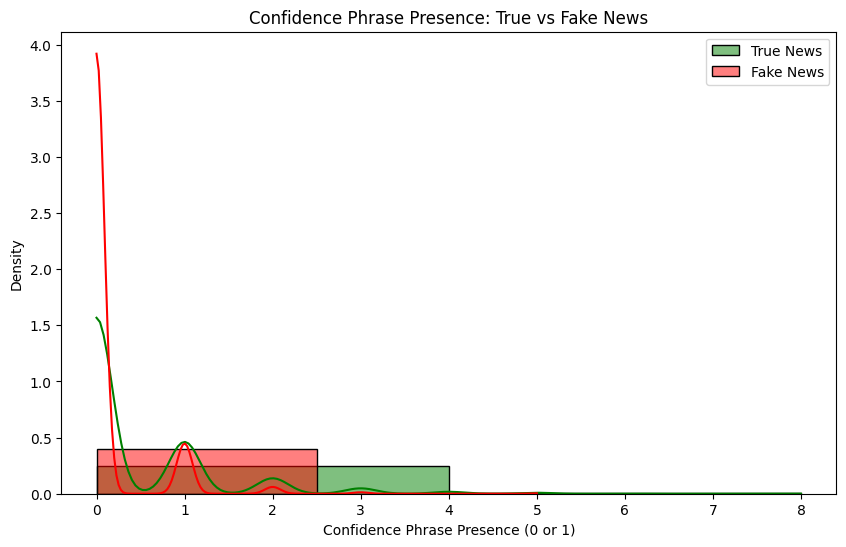

In [73]:
# 2. Графік для Наявність виразів впевненості
plt.figure(figsize=(10, 6))
sns.histplot(true_news['confidence_presence'], color='green', kde=True, label='True News', stat='density', bins=2)
sns.histplot(fake_news['confidence_presence'], color='red', kde=True, label='Fake News', stat='density', bins=2)
plt.title('Confidence Phrase Presence: True vs Fake News')
plt.xlabel('Confidence Phrase Presence (0 or 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

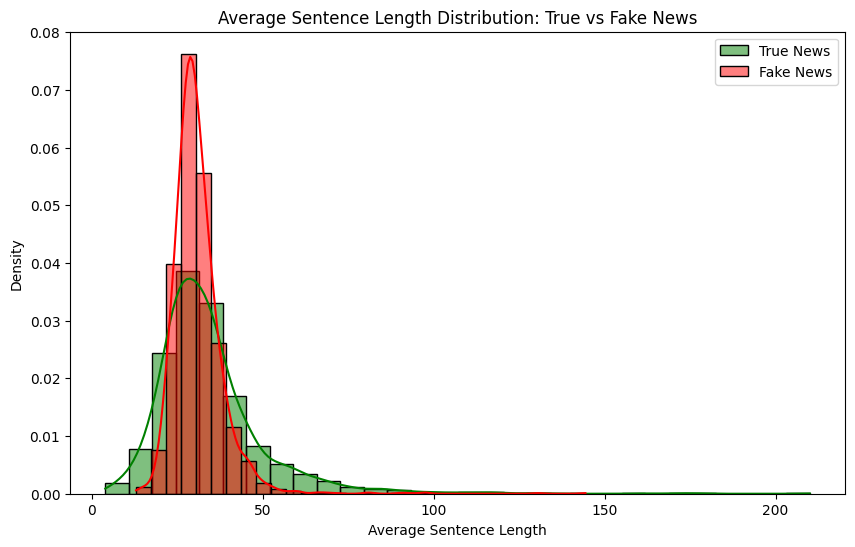

In [74]:
# 3. Графік для Середня довжина речення
plt.figure(figsize=(10, 6))
sns.histplot(true_news['avg_sentence_length'], color='green', kde=True, label='True News', stat='density', bins=30)
sns.histplot(fake_news['avg_sentence_length'], color='red', kde=True, label='Fake News', stat='density', bins=30)
plt.title('Average Sentence Length Distribution: True vs Fake News')
plt.xlabel('Average Sentence Length')
plt.ylabel('Density')
plt.legend()
plt.show()

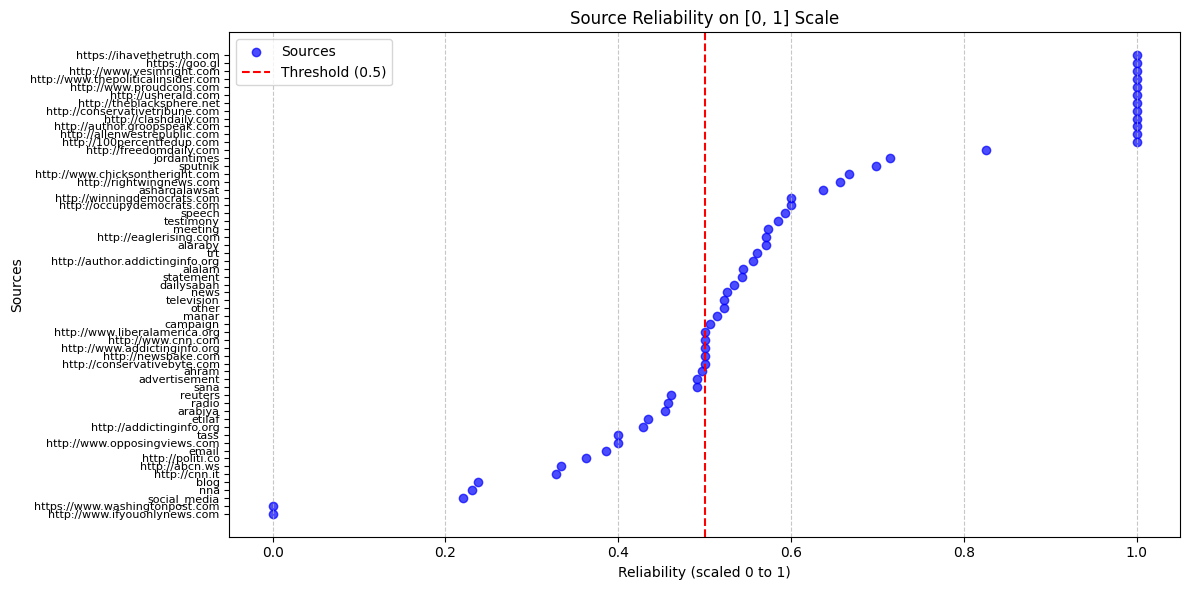

In [55]:
#4. Графік для Наадійності джерел
sorted_reliability = sorted(reliability_dictionary.items(), key=lambda x: x[1])
sources, reliabilities = zip(*sorted_reliability)
reliabilities_scaled = [r / 100 for r in reliabilities]
plt.figure(figsize=(12, 6))
plt.scatter(reliabilities_scaled, range(len(sources)), color='blue', alpha=0.7, label='Sources')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.yticks(range(len(sources)), sources, fontsize=8)
plt.xlabel("Reliability (scaled 0 to 1)")
plt.ylabel("Sources")
plt.title("Source Reliability on [0, 1] Scale")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()